In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F


dropout_value = 0.1

def conv_bn_act(in_ch, out_ch, kernel=3, stride=1, padding=1, dilation=1, dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride,
                  padding=padding, dilation=dilation, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

def dws_bn_act(in_ch, out_ch, kernel_size=3, stride=1, padding=1, dilation=1,dropout_p=0.05):
    return nn.Sequential(
        nn.Conv2d(in_ch, in_ch, kernel_size=kernel_size, stride=stride,
                            padding=padding, dilation=dilation, groups=in_ch, bias=False),
        nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_p)
    )

class Model1(nn.Module):
    def __init__(self, num_classes):
        super(Model1, self).__init__()

        # CONVOLUTION BLOCK 1
        self.c1_1 = conv_bn_act(3, 32, kernel=3, stride=1, padding=1, dilation=1)
        self.c1_2 = conv_bn_act(32, 64, kernel=3, stride=2, padding=1, dilation=1)
        self.onexonec1_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 2
        self.c2_1 = dws_bn_act(32, 64, kernel_size=3, stride=1, padding=1, dilation=1)
        self.c2_2 = dws_bn_act(64, 64, kernel_size=3, stride=2, padding=1, dilation=1)
        self.onexonec2_1 = conv_bn_act(64, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 3
        self.c3_1 = conv_bn_act(32, 64, kernel=3, stride=1, padding=1, dilation=1)
        self.c3_2 = conv_bn_act(64, 128, kernel=3, stride=2, padding=1, dilation=1)
        self.onexonec3_1 = conv_bn_act(128, 32, kernel=1, stride=1, padding=0, dilation=1)

        # CONVOLUTION BLOCK 4
        self.c4 = conv_bn_act(32, 64, kernel=3, stride=1, padding=2, dilation=1)
        self.c5 = conv_bn_act(64, 64, kernel=3, stride=2, padding=2, dilation=2)

        # OUTPUT BLOCK
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)


    def forward(self, x):
        # Block 1
        x = self.c1_1(x)
        x = self.c1_2(x)
        x = self.onexonec1_1(x)

        # Block 2
        x = self.c2_1(x)
        x = self.c2_2(x)
        x = self.onexonec2_1(x)

        # Block 3
        x = self.c3_1(x)
        x = self.c3_2(x)
        x = self.onexonec3_1(x)

        # Block 4 (dilated)
        x = self.c4(x)
        x = self.c5(x)

        # Output Block
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        # x = x.view(-1, 10)
        return x

In [15]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, test_losses, train_acc, test_acc):
    epochs = range(1, len(train_acc) + 1)

    # ----------------------
    # Plot Train Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'b-', label='Train Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Loss
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_losses, 'r-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Train Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, 'g-', label='Train Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # ----------------------
    # Plot Test Accuracy
    # ----------------------
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, test_acc, 'm-', label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

CUDA Available? True
Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 16, 16]          18,432
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           2,048
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]             288

Epoch=1 Loss=2.1261 Accuracy=18.51: 100%|██████████| 391/391 [00:18<00:00, 21.08it/s]



Test set: Average loss: 0.0158, Accuracy: 2418/10000 (24.18%)

found perfect model!!
Saved best model (acc=24.18%) to best_model.pth

EPOCH: 2


Epoch=2 Loss=1.7335 Accuracy=29.96: 100%|██████████| 391/391 [00:19<00:00, 19.96it/s]



Test set: Average loss: 0.0136, Accuracy: 3574/10000 (35.74%)

found perfect model!!
Saved best model (acc=35.74%) to best_model.pth

EPOCH: 3


Epoch=3 Loss=1.6568 Accuracy=36.33: 100%|██████████| 391/391 [00:18<00:00, 21.51it/s]



Test set: Average loss: 0.0122, Accuracy: 4282/10000 (42.82%)

found perfect model!!
Saved best model (acc=42.82%) to best_model.pth

EPOCH: 4


Epoch=4 Loss=1.4807 Accuracy=41.95: 100%|██████████| 391/391 [00:19<00:00, 20.11it/s]



Test set: Average loss: 0.0111, Accuracy: 4843/10000 (48.43%)

found perfect model!!
Saved best model (acc=48.43%) to best_model.pth

EPOCH: 5


Epoch=5 Loss=1.3044 Accuracy=45.95: 100%|██████████| 391/391 [00:18<00:00, 21.18it/s]



Test set: Average loss: 0.0101, Accuracy: 5342/10000 (53.42%)

found perfect model!!
Saved best model (acc=53.42%) to best_model.pth

EPOCH: 6


Epoch=6 Loss=1.3983 Accuracy=49.83: 100%|██████████| 391/391 [00:19<00:00, 20.37it/s]



Test set: Average loss: 0.0094, Accuracy: 5645/10000 (56.45%)

found perfect model!!
Saved best model (acc=56.45%) to best_model.pth

EPOCH: 7


Epoch=7 Loss=1.3808 Accuracy=52.93: 100%|██████████| 391/391 [00:18<00:00, 21.29it/s]



Test set: Average loss: 0.0092, Accuracy: 5891/10000 (58.91%)

found perfect model!!
Saved best model (acc=58.91%) to best_model.pth

EPOCH: 8


Epoch=8 Loss=1.1573 Accuracy=55.28: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]



Test set: Average loss: 0.0082, Accuracy: 6250/10000 (62.50%)

found perfect model!!
Saved best model (acc=62.50%) to best_model.pth

EPOCH: 9


Epoch=9 Loss=1.1912 Accuracy=57.33: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s]



Test set: Average loss: 0.0081, Accuracy: 6332/10000 (63.32%)

found perfect model!!
Saved best model (acc=63.32%) to best_model.pth

EPOCH: 10


Epoch=10 Loss=1.2129 Accuracy=59.15: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 0.0080, Accuracy: 6277/10000 (62.77%)


EPOCH: 11


Epoch=11 Loss=1.2635 Accuracy=60.43: 100%|██████████| 391/391 [00:19<00:00, 19.80it/s]



Test set: Average loss: 0.0070, Accuracy: 6849/10000 (68.49%)

found perfect model!!
Saved best model (acc=68.49%) to best_model.pth

EPOCH: 12


Epoch=12 Loss=1.1846 Accuracy=62.07: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]



Test set: Average loss: 0.0069, Accuracy: 6886/10000 (68.86%)

found perfect model!!
Saved best model (acc=68.86%) to best_model.pth

EPOCH: 13


Epoch=13 Loss=1.0760 Accuracy=63.54: 100%|██████████| 391/391 [00:19<00:00, 19.62it/s]



Test set: Average loss: 0.0065, Accuracy: 7090/10000 (70.90%)

found perfect model!!
Saved best model (acc=70.90%) to best_model.pth

EPOCH: 14


Epoch=14 Loss=1.1089 Accuracy=64.65: 100%|██████████| 391/391 [00:18<00:00, 20.75it/s]



Test set: Average loss: 0.0066, Accuracy: 7125/10000 (71.25%)

found perfect model!!
Saved best model (acc=71.25%) to best_model.pth

EPOCH: 15


Epoch=15 Loss=1.0457 Accuracy=66.10: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]



Test set: Average loss: 0.0062, Accuracy: 7232/10000 (72.32%)

found perfect model!!
Saved best model (acc=72.32%) to best_model.pth

EPOCH: 16


Epoch=16 Loss=0.7826 Accuracy=66.91: 100%|██████████| 391/391 [00:18<00:00, 20.81it/s]



Test set: Average loss: 0.0057, Accuracy: 7427/10000 (74.27%)

found perfect model!!
Saved best model (acc=74.27%) to best_model.pth

EPOCH: 17


Epoch=17 Loss=0.7742 Accuracy=67.89: 100%|██████████| 391/391 [00:20<00:00, 19.52it/s]



Test set: Average loss: 0.0055, Accuracy: 7534/10000 (75.34%)

found perfect model!!
Saved best model (acc=75.34%) to best_model.pth

EPOCH: 18


Epoch=18 Loss=1.0110 Accuracy=68.68: 100%|██████████| 391/391 [00:18<00:00, 21.03it/s]



Test set: Average loss: 0.0055, Accuracy: 7523/10000 (75.23%)


EPOCH: 19


Epoch=19 Loss=0.6211 Accuracy=69.33: 100%|██████████| 391/391 [00:19<00:00, 19.61it/s]



Test set: Average loss: 0.0057, Accuracy: 7495/10000 (74.95%)


EPOCH: 20


Epoch=20 Loss=0.8836 Accuracy=70.12: 100%|██████████| 391/391 [00:18<00:00, 20.76it/s]



Test set: Average loss: 0.0052, Accuracy: 7704/10000 (77.04%)

found perfect model!!
Saved best model (acc=77.04%) to best_model.pth

EPOCH: 21


Epoch=21 Loss=0.8892 Accuracy=70.68: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]



Test set: Average loss: 0.0052, Accuracy: 7753/10000 (77.53%)

found perfect model!!
Saved best model (acc=77.53%) to best_model.pth

EPOCH: 22


Epoch=22 Loss=0.7242 Accuracy=71.19: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]



Test set: Average loss: 0.0048, Accuracy: 7899/10000 (78.99%)

found perfect model!!
Saved best model (acc=78.99%) to best_model.pth

EPOCH: 23


Epoch=23 Loss=0.6800 Accuracy=71.55: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 0.0048, Accuracy: 7890/10000 (78.90%)


EPOCH: 24


Epoch=24 Loss=0.7062 Accuracy=72.15: 100%|██████████| 391/391 [00:19<00:00, 19.55it/s]



Test set: Average loss: 0.0047, Accuracy: 7911/10000 (79.11%)

found perfect model!!
Saved best model (acc=79.11%) to best_model.pth

EPOCH: 25


Epoch=25 Loss=0.7712 Accuracy=72.19: 100%|██████████| 391/391 [00:18<00:00, 20.62it/s]



Test set: Average loss: 0.0046, Accuracy: 7964/10000 (79.64%)

found perfect model!!
Saved best model (acc=79.64%) to best_model.pth

EPOCH: 26


Epoch=26 Loss=0.7338 Accuracy=72.72: 100%|██████████| 391/391 [00:19<00:00, 19.59it/s]



Test set: Average loss: 0.0046, Accuracy: 7933/10000 (79.33%)


EPOCH: 27


Epoch=27 Loss=0.7464 Accuracy=72.91: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s]



Test set: Average loss: 0.0045, Accuracy: 7993/10000 (79.93%)

found perfect model!!
Saved best model (acc=79.93%) to best_model.pth

EPOCH: 28


Epoch=28 Loss=0.7900 Accuracy=73.25: 100%|██████████| 391/391 [00:20<00:00, 19.00it/s]



Test set: Average loss: 0.0045, Accuracy: 8024/10000 (80.24%)

found perfect model!!
Saved best model (acc=80.24%) to best_model.pth

EPOCH: 29


Epoch=29 Loss=0.8159 Accuracy=73.67: 100%|██████████| 391/391 [00:20<00:00, 19.36it/s]



Test set: Average loss: 0.0044, Accuracy: 8107/10000 (81.07%)

found perfect model!!
Saved best model (acc=81.07%) to best_model.pth

EPOCH: 30


Epoch=30 Loss=0.6940 Accuracy=74.00: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]



Test set: Average loss: 0.0043, Accuracy: 8086/10000 (80.86%)


EPOCH: 31


Epoch=31 Loss=0.5976 Accuracy=74.10: 100%|██████████| 391/391 [00:20<00:00, 19.21it/s]



Test set: Average loss: 0.0042, Accuracy: 8149/10000 (81.49%)

found perfect model!!
Saved best model (acc=81.49%) to best_model.pth

EPOCH: 32


Epoch=32 Loss=0.8480 Accuracy=74.66: 100%|██████████| 391/391 [00:19<00:00, 20.35it/s]



Test set: Average loss: 0.0042, Accuracy: 8153/10000 (81.53%)

found perfect model!!
Saved best model (acc=81.53%) to best_model.pth

EPOCH: 33


Epoch=33 Loss=0.6534 Accuracy=75.01: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]



Test set: Average loss: 0.0044, Accuracy: 8120/10000 (81.20%)


EPOCH: 34


Epoch=34 Loss=0.7628 Accuracy=75.11: 100%|██████████| 391/391 [00:18<00:00, 20.63it/s]



Test set: Average loss: 0.0041, Accuracy: 8187/10000 (81.87%)

found perfect model!!
Saved best model (acc=81.87%) to best_model.pth

EPOCH: 35


Epoch=35 Loss=0.7626 Accuracy=75.20: 100%|██████████| 391/391 [00:19<00:00, 20.07it/s]



Test set: Average loss: 0.0040, Accuracy: 8260/10000 (82.60%)

found perfect model!!
Saved best model (acc=82.60%) to best_model.pth

EPOCH: 36


Epoch=36 Loss=0.5648 Accuracy=75.43: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 0.0040, Accuracy: 8268/10000 (82.68%)

found perfect model!!
Saved best model (acc=82.68%) to best_model.pth

EPOCH: 37


Epoch=37 Loss=0.8697 Accuracy=75.65: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]



Test set: Average loss: 0.0041, Accuracy: 8209/10000 (82.09%)


EPOCH: 38


Epoch=38 Loss=0.6942 Accuracy=75.91: 100%|██████████| 391/391 [00:20<00:00, 18.72it/s]



Test set: Average loss: 0.0039, Accuracy: 8302/10000 (83.02%)

found perfect model!!
Saved best model (acc=83.02%) to best_model.pth

EPOCH: 39


Epoch=39 Loss=0.4851 Accuracy=75.95: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.0040, Accuracy: 8271/10000 (82.71%)


EPOCH: 40


Epoch=40 Loss=0.6465 Accuracy=76.49: 100%|██████████| 391/391 [00:20<00:00, 19.31it/s]



Test set: Average loss: 0.0040, Accuracy: 8264/10000 (82.64%)


EPOCH: 41


Epoch=41 Loss=0.6386 Accuracy=76.69: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]



Test set: Average loss: 0.0039, Accuracy: 8278/10000 (82.78%)


EPOCH: 42


Epoch=42 Loss=0.6155 Accuracy=76.84: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s]



Test set: Average loss: 0.0040, Accuracy: 8261/10000 (82.61%)


EPOCH: 43


Epoch=43 Loss=0.8532 Accuracy=76.78: 100%|██████████| 391/391 [00:20<00:00, 19.32it/s]



Test set: Average loss: 0.0039, Accuracy: 8302/10000 (83.02%)

found perfect model!!
Saved best model (acc=83.02%) to best_model.pth

EPOCH: 44


Epoch=44 Loss=0.7755 Accuracy=77.11: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]



Test set: Average loss: 0.0038, Accuracy: 8348/10000 (83.48%)

found perfect model!!
Saved best model (acc=83.48%) to best_model.pth

EPOCH: 45


Epoch=45 Loss=0.7545 Accuracy=77.48: 100%|██████████| 391/391 [00:20<00:00, 19.25it/s]



Test set: Average loss: 0.0040, Accuracy: 8321/10000 (83.21%)


EPOCH: 46


Epoch=46 Loss=0.6043 Accuracy=77.74: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s]



Test set: Average loss: 0.0037, Accuracy: 8370/10000 (83.70%)

found perfect model!!
Saved best model (acc=83.70%) to best_model.pth

EPOCH: 47


Epoch=47 Loss=0.5410 Accuracy=77.72: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]



Test set: Average loss: 0.0036, Accuracy: 8437/10000 (84.37%)

found perfect model!!
Saved best model (acc=84.37%) to best_model.pth

EPOCH: 48


Epoch=48 Loss=0.6680 Accuracy=78.08: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]



Test set: Average loss: 0.0038, Accuracy: 8368/10000 (83.68%)


EPOCH: 49


Epoch=49 Loss=0.5480 Accuracy=78.24: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]



Test set: Average loss: 0.0036, Accuracy: 8430/10000 (84.30%)


EPOCH: 50


Epoch=50 Loss=0.6369 Accuracy=78.10: 100%|██████████| 391/391 [00:20<00:00, 19.41it/s]



Test set: Average loss: 0.0037, Accuracy: 8426/10000 (84.26%)


EPOCH: 51


Epoch=51 Loss=0.5545 Accuracy=78.58: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.0036, Accuracy: 8425/10000 (84.25%)


EPOCH: 52


Epoch=52 Loss=0.6300 Accuracy=78.89: 100%|██████████| 391/391 [00:20<00:00, 19.26it/s]



Test set: Average loss: 0.0035, Accuracy: 8482/10000 (84.82%)

found perfect model!!
Saved best model (acc=84.82%) to best_model.pth

EPOCH: 53


Epoch=53 Loss=0.5363 Accuracy=79.01: 100%|██████████| 391/391 [00:19<00:00, 20.36it/s]



Test set: Average loss: 0.0035, Accuracy: 8449/10000 (84.49%)


EPOCH: 54


Epoch=54 Loss=0.6768 Accuracy=79.21: 100%|██████████| 391/391 [00:20<00:00, 19.28it/s]



Test set: Average loss: 0.0036, Accuracy: 8446/10000 (84.46%)


EPOCH: 55


Epoch=55 Loss=0.6066 Accuracy=79.12: 100%|██████████| 391/391 [00:19<00:00, 19.98it/s]



Test set: Average loss: 0.0034, Accuracy: 8516/10000 (85.16%)

found perfect model!!
Saved best model (acc=85.16%) to best_model.pth
-----------------------------------------
train accuracies 55 [18.508, 29.958, 36.326, 41.946, 45.952, 49.826, 52.93, 55.284, 57.328, 59.154, 60.43, 62.068, 63.538, 64.646, 66.104, 66.912, 67.888, 68.682, 69.328, 70.124, 70.68, 71.194, 71.548, 72.146, 72.188, 72.724, 72.91, 73.252, 73.674, 73.996, 74.104, 74.664, 75.014, 75.106, 75.204, 75.432, 75.652, 75.906, 75.954, 76.488, 76.69, 76.842, 76.784, 77.114, 77.48, 77.738, 77.716, 78.082, 78.242, 78.102, 78.576, 78.892, 79.01, 79.208, 79.122]
train losses 55 [850.8173539638519, 748.6940159797668, 679.1184575557709, 623.9431948661804, 579.7111731767654, 543.5727834701538, 510.4466972351074, 486.16574025154114, 464.4953393340111, 448.43350237607956, 432.40346908569336, 417.3656471967697, 400.8991119861603, 388.06152188777924, 373.8395051956177, 365.17752742767334, 355.09601724147797, 345.6220392584801, 338.5

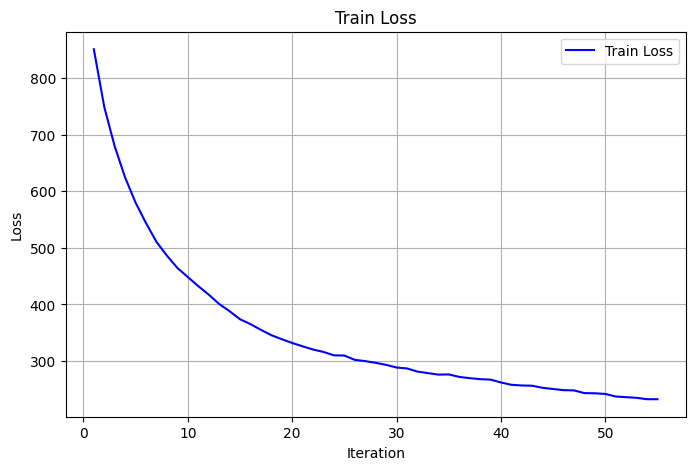

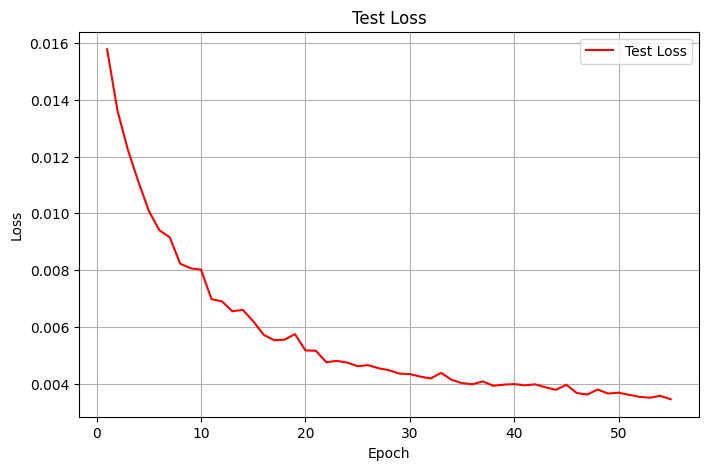

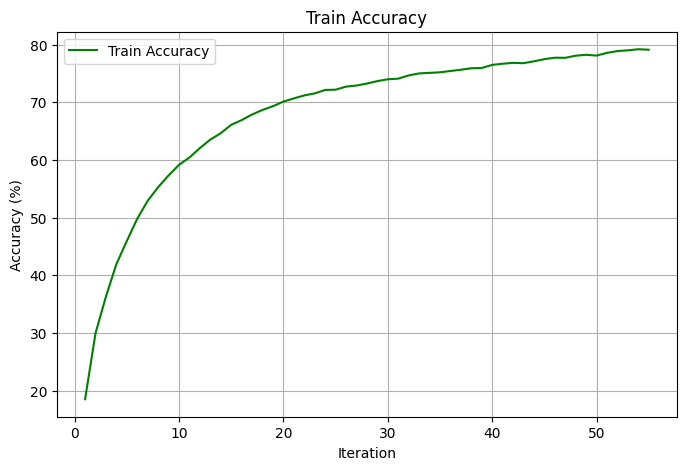

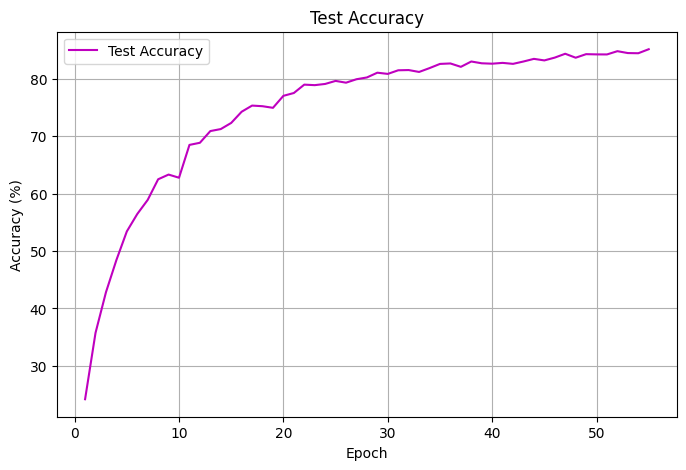

In [16]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import OneCycleLR
# from models import Model1
# from utils import plot_metrics


def train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)   # expects log_softmax in model forward
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        # if batch_idx > 5:
        #     break
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100. * correct / processed
        pbar.set_description(desc=f'Epoch={epoch} Loss={loss.item():.4f} Accuracy={acc:0.2f}')
        #train_acc.append(acc)
    train_losses.append(train_loss)
    acc = 100. * correct / len(train_loader.dataset)
    train_acc.append(acc)


def test(model, device, test_loader, criterion, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(acc)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    return acc

def get_data_loaders():
    # CIFAR-10 mean and std
    CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
    CIFAR10_STD  = (0.2470, 0.2435, 0.2616)


    fill_value_pixels = tuple(int(m * 255) for m in CIFAR10_MEAN)

    train_alb = A.Compose([
        A.HorizontalFlip(p=0.5),
         A.Affine(
            translate_percent={"x": 0.0625, "y": 0.0625},  # shift
            scale=(0.9, 1.1),                               # scale
            rotate=(-15, 15),                               # rotation
            p=0.5
        ),
        A.CoarseDropout(
            num_holes_range=(1, 1),
            hole_height_range=(16, 16),
            hole_width_range=(16, 16),
            fill=fill_value_pixels,
            fill_mask=None,
            p=0.5
        ),
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    val_alb = A.Compose([
        A.Normalize(mean=CIFAR10_MEAN, std=CIFAR10_STD),
        ToTensorV2(),
    ])

    class AlbCIFAR10(datasets.CIFAR10):
        def __init__(self, root, train=True, transform=None, download=False):
            super().__init__(root=root, train=train, download=download)
            self.alb_transform = transform

        def __getitem__(self, index):
            img, target = self.data[index], int(self.targets[index])
            # img is HxWxC numpy (uint8)
            if self.alb_transform:
                augmented = self.alb_transform(image=img)
                img = augmented["image"]
            else:
                # fallback: convert to tensor and normalize
                img = transforms.ToTensor()(img)
            return img, target



    # train_transforms = transforms.Compose([
    #     transforms.RandomHorizontalFlip(),
    #     transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # test_transforms = transforms.Compose([
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean, std)
    # ])

    # train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
    # test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

    train = AlbCIFAR10(root='./data', train=True, transform=train_alb, download=True)
    test   = AlbCIFAR10(root='./data', train=False, transform=val_alb, download=True)

    SEED = 1
    cuda = torch.cuda.is_available()
    print("CUDA Available?", cuda)
    torch.manual_seed(SEED)
    if cuda:
        torch.cuda.manual_seed(SEED)

    dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda \
                      else dict(shuffle=True, batch_size=64)
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
    return train_loader, test_loader, cuda

def perform_training():
    train_loader, test_loader, use_cuda = get_data_loaders()
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Using device:", device)

    number_of_classes = 10
    model = Model1(number_of_classes).to(device)
    summary(model, input_size=(3, 32, 32))  # CIFAR-10 input size

    # return
    #optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

    # scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    EPOCHS = 80
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),

        epochs=EPOCHS,
        pct_start=0.2,
        anneal_strategy="cos",
    )

    EPOCHS = 100
    SAVE_PATH = "best_model.pth"

    train_losses, test_losses, train_acc, test_acc = [], [], [], []
    best_val_acc = 0.0

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEPOCH: {epoch}")
        train(model, device, train_loader, optimizer, scheduler, criterion, epoch, train_losses, train_acc)
        current_test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)
        if current_test_acc >= best_val_acc:
            print("found perfect model!!")
            best_val_acc = current_test_acc
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": current_test_acc,
            }, SAVE_PATH)
            print(f"Saved best model (acc={best_val_acc:.2f}%) to {SAVE_PATH}")
            if best_val_acc >= 85.0:
                break

    print("-----------------------------------------")
    print("train accuracies", len(train_acc), train_acc)
    print("train losses", len(train_losses), train_losses)
    print("-----------------------------------------")
    print("-----------------------------------------")
    print("test accuracies", len(test_acc), test_acc)
    print("test losses", len(test_losses), test_losses)
    print("-----------------------------------------")
    plot_metrics(train_losses, test_losses, train_acc, test_acc)

if __name__ == '__main__':
    perform_training()